<h3>Header</h3>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h5>External Modules</h5>

In [2]:
# Utils
import matplotlib.pyplot as plt
import random
import os
from PIL import Image
import numpy as np
import sys

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
from  torch.nn.modules.upsampling import Upsample

In [3]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [4]:
# MacOs
# device = 'mps' if torch.backends.mps.is_available()  else 'cpu'

# Ubuntu/Colab
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Force to use cpu device
#device = 'cpu'

print(f"Using {device} device")

Using cuda device


In [5]:
# Main directory
main_dir = '/content/drive/MyDrive/Università/Artificial Intelligence and Robotics/1° Anno/2° Semestre/Vision and Perception/Project/Colorization-SuperResolution/'

<h5>Internal Modules</h5>

In [6]:
# To use internal modules in Colab
sys.path.insert(0, main_dir)

from dataset import pikfix_dataset, plot_data
from utils.degrade_image import degrade_image
from models.restoration_subnet import RestorationSubNet
from loss.loss import LuminanceReconstructionLoss, PerceptualLoss

<h5>Data path</h5>

In [7]:
# Data directory and csv file
data_dir = main_dir + 'data/'
csv_file = data_dir + 'dataset.csv'

# Weights directory
weights_dir = main_dir + 'weights/'

In [8]:
NUM_EPOCHS = 10

<h3>Main</h3>

Image degradation

In [9]:
# # Images and textures folder
# images_folder = "data/res"
# textures_folder = "data/textures"

# # Select a random image
# random_img = os.path.join(images_folder, random.choice(os.listdir(images_folder)))

# # Degrade it
# ruined_version = degrade_image(img=random_img, textures_folder=textures_folder, degradation_level=4, scaling_factor=4)

# # Plot the result
# fig, axs = plt.subplots(1, 2, figsize=(12,12))

# plt.subplot(1,2,1)
# plt.imshow(Image.open(random_img), cmap='gray')

# plt.title(f'Original')
# plt.axis('off')

# plt.subplot(1,2,2)
# plt.imshow(ruined_version, cmap='gray')
# plt.title(f'Ruined')
# plt.axis('off')

# #plt.savefig("version1.jpeg", bboh_inches='tight')

Import dataset

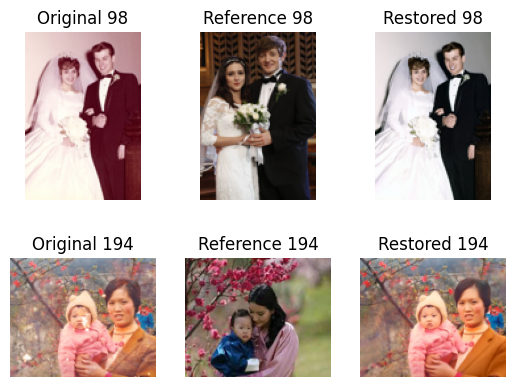

In [10]:
# Define the transformation to be applied on the images in the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# Build dataset
dataset = pikfix_dataset.PikFixData(csv_file, data_dir, transform, max_size=128)

# Plot some random samples
plot_data.plot_random_samples(2, dataset)

In [11]:
# To plot the output of RestorationSubNet without training on the last convolutional layer and finetuning
'''

tl = DataLoader(dataset=dataset, batch_size=1, shuffle=True)
it = iter(tl)

original, _, _ = next(it)
original = original.to(torch.float32).to(device)

restorationNet = RestorationSubNet(weights=weights_dir, scale=4).to(device)
out = restorationNet(original)

plt.subplots(1,2, figsize=(8,4))

plt.subplot(1,2,1)
original = original.cpu()
plot_data.imshow(original.detach().squeeze())

plt.subplot(1,2,2)
out = out.cpu()
plt.imshow(out.detach().numpy().transpose(1,2,0), cmap='gray')

'''

"\n\ntl = DataLoader(dataset=dataset, batch_size=1, shuffle=True)\nit = iter(tl)\n\noriginal, _, _ = next(it)\noriginal = original.to(torch.float32).to(device)\n\nrestorationNet = RestorationSubNet(weights=weights_dir, scale=4).to(device)\nout = restorationNet(original)\n\nplt.subplots(1,2, figsize=(8,4))\n\nplt.subplot(1,2,1)\noriginal = original.cpu()\nplot_data.imshow(original.detach().squeeze())\n\nplt.subplot(1,2,2)\nout = out.cpu()\nplt.imshow(out.detach().numpy().transpose(1,2,0), cmap='gray')\n\n"

In [12]:
# Define train loader, restorationSubNet, optimizer and loss functions

train_loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)

restorationNet = RestorationSubNet(weights=weights_dir, scale=4).to(device)

optimizer = optim.Adam(restorationNet.parameters(), lr=0.0001, betas=(0.99, 0.999))

luminance_reconstruction_loss = LuminanceReconstructionLoss().to(device)
perceptual_loss = PerceptualLoss().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
# Training stage
#'''
for epoch in range(NUM_EPOCHS):
    print(f"Epoch [{epoch + 1} of {NUM_EPOCHS}]")
    restorationNet.train()
    train_loss = 0.0

    for idx, (original, reference, restored) in enumerate(train_loader):
        original = original.to(torch.float32)
        reference = reference.to(torch.float32)
        restored = restored.to(torch.float32)

        original = original.to(device)
        reference = reference.to(device)
        restored = restored.to(device)

        optimizer.zero_grad()
        output = restorationNet(original)
        
        tr = transforms.Compose([transforms.Grayscale(num_output_channels=1), Upsample(scale_factor=4)])
        restored = tr(restored)
        restored = restored.resize(restored.shape[1], restored.shape[2], restored.shape[3])

        lr_loss = luminance_reconstruction_loss(output, restored)
        p_loss = perceptual_loss(output, restored)

        loss = 1.0*lr_loss + 0.2*p_loss

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        #print(f"Loss: {loss.item()}")

        if (idx + 1) % 20 == 0:
            #print(f"Batch {idx + 1}/{len(train_loader)} Loss: {loss.item()}")
            print(f"Loss: {loss.item()}")
            torch.save(restorationNet, main_dir + 'models/weights/restoration_subnet_weights.pt')
    
    print('----------------------------------------------------------------------')

    # Calculate average training loss for the epoch
    train_loss /= len(train_loader)
    print(f"Train Loss: {train_loss}")

torch.save(restorationNet, main_dir + 'models/weights/restoration_subnet_weights.pt')
#'''

Epoch [1 of 10]


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Loss: 1.8789994716644287
Loss: 2.556107521057129
Loss: 1.757885217666626
Loss: 2.805504083633423
Loss: 1.7645282745361328
Loss: 1.7006723880767822
Loss: 2.4288346767425537
Loss: 3.221646547317505
Loss: 2.828935384750366
Loss: 3.3755598068237305
----------------------------------------------------------------------
Train Loss: 2.4446398437023165
Epoch [2 of 10]
Loss: 2.719367742538452
Loss: 2.0042595863342285
Loss: 2.4905223846435547
Loss: 1.7418301105499268
Loss: 1.767237901687622
Loss: 2.899050235748291
Loss: 2.6472394466400146
Loss: 1.7025489807128906
Loss: 2.700774908065796
Loss: 1.756777286529541
----------------------------------------------------------------------
Train Loss: 2.2889251524209975
Epoch [3 of 10]
Loss: 1.5234522819519043
Loss: 2.1427767276763916
Loss: 2.186361074447632
Loss: 2.1074163913726807
Loss: 1.5834654569625854
Loss: 1.3768136501312256
Loss: 1.8409329652786255
Loss: 2.212332248687744
Loss: 2.5550308227539062
Loss: 1.5573736429214478
--------------------------

In [14]:
restorationSubnet = torch.load(main_dir + 'models/weights/restoration_subnet_weights.pt', map_location=torch.device('cpu'))
it = iter(train_loader)

In [ ]:
original, _, restored = next(it)
original = original.to(torch.float32).to('cpu')
restored = restored.to(torch.float32).to('cpu')

# output without training
rest = RestorationSubNet(weights=weights_dir, scale=4).to('cpu')
out1 = rest(original)

# output with training
out2 = restorationSubnet(original)

In [ ]:
# Plots
plt.subplots(1,4, figsize=(16,4))

plt.subplot(1,4,1)
plot_data.imshow(original.detach().squeeze())
plt.title('Original')

plt.subplot(1,4,2)
plot_data.imshow(restored.detach().squeeze())
plt.title('Restored')

plt.subplot(1,4,3)
plt.imshow(out1.detach().numpy().transpose(1,2,0), cmap='gray')
plt.title('Output without training')

plt.subplot(1,4,4)
plt.imshow(out2.detach().numpy().transpose(1,2,0), cmap='gray')
plt.title('Output with training')